# CIFAR-10 이미지 생성하기

GAN을 이용해서 CIFAR-10의 이미를 만들어보자.

## 0. 모듈 import

In [1]:
import os
import glob
import time

import PIL
import imageio
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from matplotlib.pylab import rcParams
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## 1. 데이터셋 구성하기

keras에 내장된 cifar10을 불러와서 사용한다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

잘 불러와 졌는지 출력해보자.

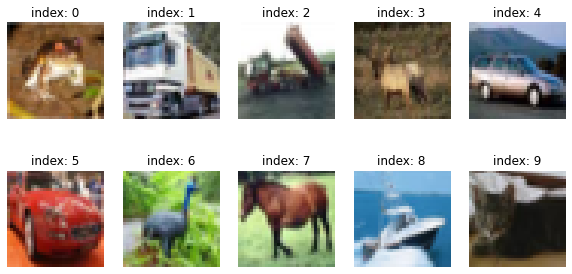

In [3]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


픽셀이 0~255범위로 학습의 용이성을 위해서 -1~ 1범위로 정규화 시켜주자.

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


다만 출력을 할때 pyplot은 0 ~ 255범위의 정수와  
0.0 ~ 1.0 사이의 실수를 그릴 수 있다.

출력을 할때는 (image+1)*0.5로 0~1의 범위로 바꾸어 주어야 한다.

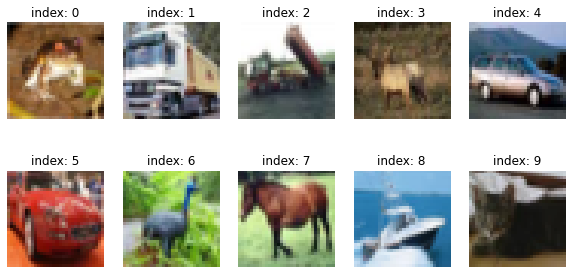

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]+1)*0.5)
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

In [7]:
train_x.shape

(50000, 32, 32, 3)

총 데이터 개수는 50000개이고, 32 * 32 크기에 rgb 채널을 가지는 데이터 셋이다.

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

학습 효율을 올리기 위해 설정된 배치값으로 데이터 셋을 구성하자.

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. 생성자 모델 구현하기

생성자는 랜덤한 노이즈 벡터를 받아서 32*32*3의 이미지를 출력하는 모델이다.

노이즈 벡터의 크기를 100으로 잡고 Conv2DTranspose로 업샘플링을 시켜주자.  
생성기 출력의 마지막 레이어는 Tanh으로 하는게 결과가 더 좋다고 한다.

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

출력 결과로 32 * 32 * 3 인걸 확인했다.

그럼 다음으로 노이즈 벡터를 하나 생성해서 모델에 넣어보자.
tf.random.normal을 이용하면 가우시안 분포에서  
뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.  
GAN에서는 일반적으로 가우시안 분포의 노이즈가 성능이 더 좋다고한다.

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

하나의 노이즈 벡터를 넣었을 때 32 * 32 * 3의 이미지가 나온것을 확인 할 수 있다.

현재 전혀 학습이 안된 모델이라 전혀 의미 없는 이미지가 나온다.

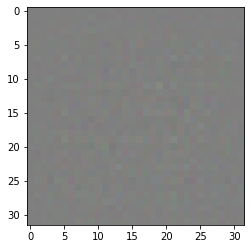

In [14]:
plt.imshow((generated_image[0] + 1) * 0.5)
plt.show()

##  3. 판별자 모델 구현하기

판별자는 가짜 이미지와 진짜 이미지를 입력받으면  
각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 한다.

32*32*3 이미지를 입력으로 받아 하나의 실수값을 내놓아야 한다.  
(이후 sigmoid등을 이용해서 0~1사이의 확률로 변경할 것이다. )

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

하나의 실수를 출력을 확인 할 수 있다.

이번에는 생성자에서 만든 1개의 이미지를 넣어서 결과를 출력해보자.

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00205376]], dtype=float32)>

## 4. 손실함수와 최적화 함수 구현하기

각 모델을 학습시키기 위해 오차함수와 최적화함수를 만들어야한다.

결과가 하나의 실수이므로 0~1사의 실수로 변경해서 BinaryCrossentropy를 사용하자.  
생성자의 경우 label값은 이미지가 같아야 하므로 1이다.

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

판별자의 경우 가짜 이미지의 라벨은 0으로,  
진짜 이미지의 라벨은 1이 되게 오차를 구하자.

판별자의 최종 오차값은 두 값을 합친 값이 된다.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

학습 결과를 보기위한 정확도도 구해주자.

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

그리고 매 학습시마다 결과가 어떻게 바뀌는지 확인하기 위해  
일정한 노이즈 벡터를 선언해 놓자.  
매번 5*5로 25개의 그림을 출력하기 위해 (100, 25)노이즈 벡터를 만든다.

In [23]:
noise_dim = 100
num_examples_to_generate = 25

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([25, 100])

##  5. 훈련과정 상세 기능 구현하기

다음은 학습시 한번에 배치마다 어떻게 학습할 지를 정하는 함수이다.

In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

다음은 학습 중 미리 만들어둔 노이즈 벡터로 부터 이미지를 만들어서  
출력하고 저장하는 함수이다.

In [25]:
generated_sample_prefix = ''

def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    predictions = (predictions + 1) * 0.5

    fig = plt.figure(figsize=(5, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
        
    plt.savefig(f'save/generated_samples/{generated_sample_prefix}_sample_epoch_{epoch:04d}_iter_{it:03d}.png')

    plt.show()

매 에폭마다의 학습과정을 출력하고 저장하는 함수이다.

In [26]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
train_history_prefix = ''

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(f'save/training_history/{train_history_prefix}_train_history_{epoch:04d}.png')
    plt.show()

### 체크포인트 설정

In [27]:
checkpoint_dir = 'save/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 6. 학습 과정 진행하기

실제 학습하는 함수이다.  
매 50배치 마다 만들어진 결과를 출력하고 저장한다.

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

총 50번의 에폭을 반복하고, 5번의 에폭마다 체크포인트에 저장한다.

In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

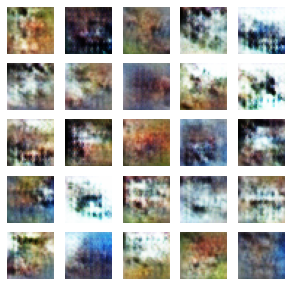

Time for training : 1189 sec


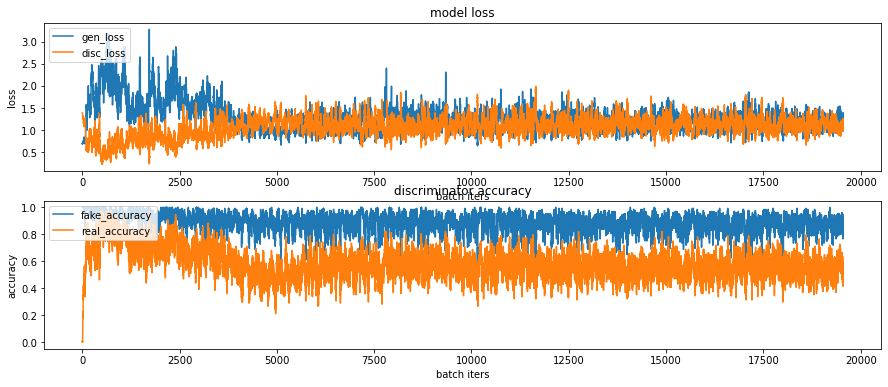

Wall time: 19min 56s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

마지막으로 만들어진 출력 결과를 확인해보면 그다지 잘 학습되지 않은 것 같다.

학습결과들을 보면 real_accuracy는 0.5로 얼추 수렴해 나가는 것 같아보인다.  
fake_accuracy는 첫번째 에폭에서의 학습과정을 보면 거의 1에 붙어 있지만  
마지막 학습과정에서는 그나마 fake_accuracy가 변동은 있어보인다.

다만, 여전히 0.8이하로 잘 떨어지지 않고 있다.  
생성기가 학습하며 만든 모델을 판별기가 잘 판단하지 못하는 것 같다.

![first](save/training_history/_train_history_0000.png)

### 생성이미지 학습 과정 gif

In [31]:
anim_file = 'save/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(f'save/generated_samples/{generated_sample_prefix}_sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

![SegmentLocal](save/cifar10_dcgan.gif "segment")

뭔가 이미지를 학습되어 같기는 하지만 딱히 라벨을 붙힐만큼  
명확한 이미지를 못만들고 있다.  

에폭 100회까지는 조금 선명해지지만 여전히 불명확한 이미지이고,  
그 뒤로는 개선이 잘되지 않는다.

## 7. GAN 훈련 과정 개선하기

GAN에 대해 찾은 몇가지 개선 방법 적용해보자.
- 입력 노이즈 벡터 크기 늘리기
- 배치 크기를 줄이기
- Label Smoothing 사용하기
- Noisy Labels 사용하기
- 실제 이미지와 가짜 이미지의 분리 배치
- Transposed Convolution 대신 Upsampling 사용해보기

https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5

https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/

생성자 레이어를 늘리고, 노이즈 벡터의 크기도 256으로 늘렸다.  
BatchNormalization을 사용하면 오히려 초반 학습이 잘 안되서 빼버렸다.

In [50]:
def make_generator_model():
    model = tf.keras.Sequential()

    # foundation for 4x4 image
    model.add(layers.Dense(4*4*256, input_shape=(256,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((4, 4, 256)))

    # upsample to 8x8
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # output layer
    model.add(layers.Conv2D(3, (3, 3), activation='tanh', padding='same'))

    return model

In [51]:
generator = make_generator_model()
generator.summary()

ERROR! Session/line number was not unique in database. History logging moved to new session 703
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 128)       262272    
________________________

32 * 32 * 3 의 생성이미지를 출력하는 것을 확인 할 수 있다.

다음으로 판별기도 레이어를 한 층 늘렸다.

In [52]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Flatten Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))

    # classifier
    model.add(layers.Dense(1))
    return model

In [ ]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.2)

진짜와 가짜 이미지의 배치를 따로 학습시키고,  
판별기의 진짜와 가짜를 나눠서 2번 학습시킨다.

binary_cross_entropy에 Adam으로 compile 한 후,  
매 배치마다 train_on_batch으로 각각 나누어서 학습 시킬것이다.

label_smoothing=0.2  
학습 시에 정규화 효과를 주기 위해 label_smoothing 을 사용하였다.

In [56]:
discriminator = make_discriminator_model()
discriminator.compile(loss=binary_cross_entropy, metrics=['accuracy'],
                     optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5))
discriminator.summary()

ERROR! Session/line number was not unique in database. History logging moved to new session 707
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 8, 8, 128)         0         
_______________________

판별기가 진짜, 가짜 나누어서 2번을 학습 하기 때문에  
균형을 맞추려고 생성기의 배치 크기를 2배로 늘리고 따로 학습시킨다.

이를 편하게 하기 위해 판별기를 멈추고 생성기만 학습하는 모델을 따로 compile하였다.

In [57]:
discriminator.trainable = False
merge_model = tf.keras.Sequential()
merge_model.add(generator)
merge_model.add(discriminator)
merge_model.compile(loss=binary_cross_entropy, optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5))

In [63]:
noise_dim = 256
BATCH_SIZE = 64

label_dobule = np.ones([BATCH_SIZE*2, 1])
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([25, 256])

위에서 말했듯 노이즈 벡터를 256으로 늘리고 배치 사이즈를 64로 줄였다.

그에 맞게 생성이미지 확인용 노이즈 벡터를 따로 만들었다.

그리고 다음의 train_step 에서 매 배치마다 진짜 이미지와  
가짜 이미지의 2개 데이터의 라벨을 바꾸었다.  
이는 Noisy Labels로 위에서 처리한 smoothing label처럼 정규화 효과를 준다.  
dropout과 비슷한 원리가 아닐까 싶다.

In [59]:
def train_step(images):
    label_ones = np.ones([BATCH_SIZE, 1])
    label_zeors = np.zeros([BATCH_SIZE, 1])
    
    r = random.sample(range(BATCH_SIZE), 2)
    label_ones[r], label_zeors[r] = 0, 1

    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    generated_images = generator(noise)
    
    real_loss, real_accuracy = discriminator.train_on_batch(images, label_ones)
    fake_loss, fake_accuracy = discriminator.train_on_batch(generated_images, label_zeors)
    disc_loss = real_loss + fake_loss

    noise_double = tf.random.normal([BATCH_SIZE*2, noise_dim])
    gen_loss = merge_model.train_on_batch(noise_double, label_dobule)

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

중간 마다 저장하는 데이터가 중복되지 않도록  
접두사를 변경/추가 하였다.

In [60]:
generated_sample_prefix = 'ex'
train_history_prefix = 'ex'
checkpoint_prefix = os.path.join(checkpoint_dir, "ex_ckpt")
anim_file = 'save/ex_cifar10_dcgan.gif'

In [61]:
def train(dataset, epochs, save_every):
    start = time.time()
    bat_per_epo = int(dataset.shape[0] / BATCH_SIZE)
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it in range(bat_per_epo):
            idx = np.random.randint(0, dataset.shape[0], BATCH_SIZE)
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(dataset[idx])
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))
        
        draw_train_history(history, epoch)

시간이 없어서 50번만 학습 시켜보았다.

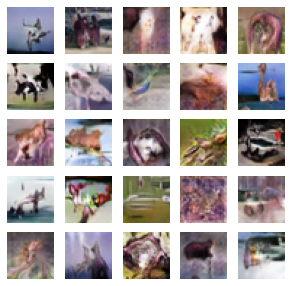

Time for training : 3614 sec


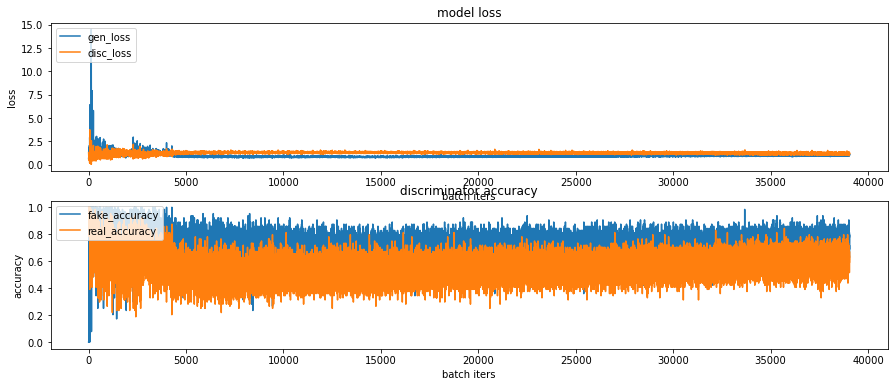

Wall time: 1h 14s


In [64]:
%%time
train(train_x, EPOCHS, save_every)

확실히 이전보다 많이 개선된 것을 확인 할 수 있다.  
아직도 fake_accuracy가 조금 높지만 그래도 0.8 아래로  
줄어드는것을 확인할 수 있다.

![f](save/training_history/ex_train_history_0000.png)

In [66]:
# gif
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('save/generated_samples/ex_sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

![SegmentLocal2](save/ex_cifar10_dcgan.gif "segment")

## 회고

재미있는 프로젝트였다.

Upsampling등 몇가지는 시간이 없어서 못했지만 나중에 따로 공부해봐야겠다.
시간이 없다 11시 56분..